In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import mysql.connector
sql_config = {
    'user': 'root',
    'password': 'see-cret',
    'database': 'tcc'
}


In [48]:
estatisticas = pd.read_csv('estatisticas_conf.csv', header = 0)
estatisticas

,edicao_do,paragrafo,confianca
0,2922,0,0.000000
1,2922,1,0.000605
2,2922,2,0.000000
3,2922,3,0.032316
4,2922,4,0.005302
...,...,...,...
2009952,3189,2302,0.028073
2009953,3189,2303,1.032651
2009954,3189,2304,0.720665
2009955,3189,2305,1.406380


In [68]:
edicoes = {}
for edicao_num in estatisticas['edicao_do'].unique():
    slc = estatisticas[estatisticas['edicao_do'] == edicao_num]
    edicoes[edicao_num] = slc['paragrafo'].max()
edicoes_df = pd.DataFrame(edicoes.items(), columns = ['edicao_do', 'max_paragrafo'])
edicoes_df

,edicao_do,max_paragrafo
0,2922,1311
1,3451,2720
2,3102,2104
3,3210,2647
4,2951,1555
...,...,...
945,3035,1667
946,3128,1551
947,3218,900
948,2727,1167


      edicao_do  paragrafo  confianca
918        2922        918  12.424381
921        2922        921  13.705620
922        2922        922   9.164628
925        2922        925  20.879584
926        2922        926  19.193300
974        2922        974  18.313640
975        2922        975  19.787011
979        2922        979  14.074758
980        2922        980  18.950185
981        2922        981  19.196089
991        2922        991   9.072372
992        2922        992  10.563647
1000       2922       1000  12.770943
1101       2922       1101  18.484095


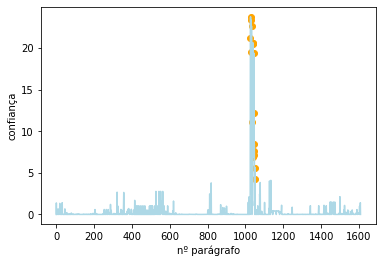

In [168]:
def get_percentil_df(val, edicao_do):
    df_edicao = estatisticas[estatisticas['edicao_do'] == edicao_do]
    x = df_edicao['paragrafo']
    y = df_edicao['confianca']

    percentil = df_edicao['confianca'].quantile(val)
    
    return df_edicao[df_edicao['confianca'] > percentil]
    
edicao_do = estatisticas['edicao_do'].unique()[0]
print(get_percentil_df(.99, edicao_do))

x_p = df_edicao[df_edicao['confianca'] > percentil]['paragrafo']
y_p = df_edicao[df_edicao['confianca'] > percentil]['confianca']

plt.xlabel('nº parágrafo')
plt.ylabel('confiança')
plt.plot(x, y, color = 'lightblue')
plt.scatter(x_p, y_p, color = 'orange')

In [193]:
import requests
web_session = requests.session()
base_url = 'http://10.0.0.20:8000/'
web_session.post(base_url + 'comparador/')

<Response [403]>

In [194]:
with mysql.connector.connect(**sql_config) as connection:
    cursor = connection.cursor()
    
    for edicao_do in tqdm(estatisticas['edicao_do'].unique()):
        percentil_df = get_percentil_df(.99, edicao_do)
        for n, edicao_do, paragrafo, confianca in percentil_df.itertuples():
            cursor.execute('SELECT paragrafo_id FROM paragrafo WHERE edicao = %s AND paragrafo = %s', (edicao_do, paragrafo))
            paragrafo_id, = cursor.fetchone()
            cursor.fetchall()
            web_response = web_session.get(base_url + 'comparador/comparar/' + str(paragrafo_id) + '/api')
            with open('percentil.csv', 'a') as file:
                file.write(str(paragrafo_id)+ ',' + web_response.text)

100%|██████████| 950/950 [31:33:47<00:00, 119.61s/it]   


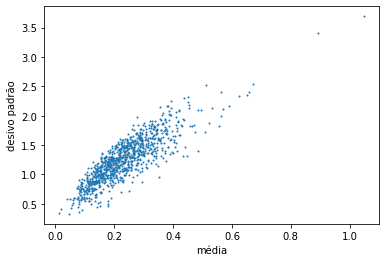

In [83]:
edicoes_n = len(edicoes_df)
means = np.zeros(edicoes_n)
stds = np.zeros(edicoes_n)
for n, edicao_do in enumerate(edicoes_df['edicao_do']):
    edicao_df = estatisticas[estatisticas['edicao_do'] == edicao_do]
    means[n] = edicao_df['confianca'].mean()
    stds[n] = edicao_df['confianca'].std()

plt.xlabel('média')
plt.ylabel('desivo padrão')
plt.scatter(means, stds, s=1)

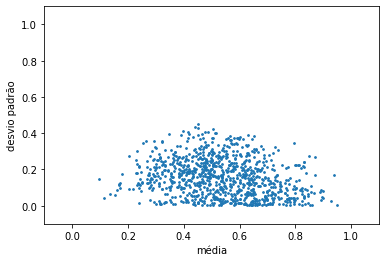

In [162]:
edicoes_n = len(edicoes_df)
means = np.zeros(edicoes_n)
stds = np.zeros(edicoes_n)

for n, edicao_do, max_paragrafo in edicoes_df.itertuples():
    edicao_df = estatisticas[estatisticas['edicao_do'] == edicao_do]
    # quantil 0.0 vira um blob no meio com desvio aprox. .3
    percentil = edicao_df['confianca'].quantile(.99)
    acima = edicao_df[edicao_df['confianca'] > percentil]
    
    x_p = (acima['paragrafo'])/max_paragrafo
    means[n] = x_p.mean()
    stds[n] = x_p.std()

plt.xlabel('média')
plt.ylabel('desvio padrão')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.scatter(means, stds, s=3)
